# Air Quality in Houston - Step 3: Feature Engineering 


### Table of Contents

  *  [3.0. Import Libraries and Datasets](#section3_0)

  *  [3.1. Indoor vs. Outdoor (RIOPA)](#section3_1)

     * [3.1.1. Considerations](#section3_1_1)

     * [3.1.2. Feature Engineering Coding](#section3_1_2)
  
     * [3.1.3. Train Test Split](#section3_1_3)
  
     * [3.1.4. Export to File](#section3_1_4)


  *  [3.2. Outdoor Air Quality (TECQ/EPA)](#section3_2)

     * [3.2.1. Considerations](#section3_2_1)

     * [3.2.2. Feature Engineering Coding](#section3_2_2)
  
     * [3.2.3. Train Test Split](#section3_2_3)

     * [3.2.4. Export to File](#section3_2_4)


<a class="anchor" id="section3_0"></a>
### 3.0. Import libraries and Datasets

The datasets are being imported from the folder "02_EDA".

In [1]:
### Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import matplotlib as mpl
import seaborn as sns
import scipy.stats as sst
from scipy.spatial.distance import squareform, pdist, cdist
import geopandas as gp
import json
import copy
from collections import defaultdict,OrderedDict, namedtuple
from sklearn.preprocessing import OneHotEncoder
import descartes
from IPython.display import Image 
from functools import reduce

import os
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
#import AQI_Toolbox

### Location of dataframes and mapping files
path_header='C:\\Users\\Anne\\Documents\\GIT\\TheFoxerine\\'
path_df='CP2_AQ_HOUSTON\\00_SavedDataframes\\'
path_saf='CP2_AQ_HOUSTON\\00_StuffAndThings\\'
path_demog='CP2_AQ_HOUSTON\\00_OriginalData\\DEMOG\\'
path_eda='CP2_AQ_HOUSTON\\02_EDA\\'
path_feat='CP2_AQ_HOUSTON\\03_Feature\\'

In [2]:
### import aqitoolbox
### disabled until final version
# %run ./aqitoolbox.ipynb
# import aqitoolboc

In [3]:
### Create a dictionary of dataframe so that I know where to find
### the material I need without having to endlessly scroll up and down.

### empty dictionary that will contain filenames and dataframes ###
eda_df = {}
path_len=len(path_header+path_eda)
file_extension=len('.csv')

### glob fetches all xls files in the folder ###
allfiles = glob.glob(path_header+path_eda + '*.csv')

### Because Python is all about dictionaries ;) ###
for filename in allfiles:
    df = pd.read_csv(filename,index_col=0)
    filename=filename[path_len::]
    filename_len=len(filename)
    filename=filename[0:(filename_len-file_extension)]
    key_name = str(filename)    
    eda_df[key_name] = copy.deepcopy(df)

### dico_df is ready
### the key is the name of the df
### the value is the df itself
print(eda_df.keys())


dict_keys(['eda_co', 'eda_no2', 'eda_ozone', 'eda_pm10', 'eda_pm25', 'eda_riopa', 'eda_so2'])


In [4]:
### Let's unwrap all df with the correct name
for k,v in eda_df.items():
    globals()[f'{k}'] =v
    
### Let's look at one df, epa_co
eda_co.head()

,co,site_lat,site_lon,landuse_main,landuse_near,dust_sand,rain_prcp,smoke_haze,station_code,station_lat,...,wind_dmg,temp_avg,wind_all,year,date.1,traffic,traffic_bins,growth,pop_binned,pop_bins
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,0.1,29.752778,-95.350278,Industrial,Industrial,0,0.0,0,USW00012918,29.63806,...,0,51.0,1,2008,2008-01-01,2941800.0,T13,1.221053,"(1.0, 1.25]",P3
2008-01-01,0.1,29.752778,-95.350278,Industrial,Industrial,0,0.0,0,USW00012918,29.63806,...,0,51.0,1,2008,2008-01-01,2941800.0,T13,1.221053,"(1.0, 1.25]",P3
2008-01-01,0.1,29.752778,-95.350278,Industrial,Industrial,0,0.0,0,USW00012918,29.63806,...,0,51.0,1,2008,2008-01-01,2941800.0,T13,1.221053,"(1.0, 1.25]",P3
2008-01-01,0.1,29.752778,-95.350278,Industrial,Industrial,0,0.0,0,USW00012918,29.63806,...,0,51.0,1,2008,2008-01-01,2941800.0,T13,1.221053,"(1.0, 1.25]",P3
2008-01-01,0.1,29.752778,-95.350278,Industrial,Industrial,0,0.0,0,USW00012918,29.63806,...,0,51.0,1,2008,2008-01-01,2941800.0,T13,1.221053,"(1.0, 1.25]",P3


<a class="anchor" id="section3_1"></a>
### 3.1. Indoor vs. Outdoor (RIOPA)

In [5]:
eda_riopa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406 entries, 1999-06-23 to 2001-02-07
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25_in            406 non-null    float64
 1   landuse            406 non-null    object 
 2   common_id          406 non-null    object 
 3   pm25_pt_in         406 non-null    float64
 4   ambient_temp_c_in  406 non-null    float64
 5   airexrate_in       406 non-null    float64
 6   ambient_rh_in      406 non-null    float64
 7   tempdry_in         406 non-null    float64
 8   dew_point_in       406 non-null    float64
 9   temp_wet_in        406 non-null    float64
 10  rh_in              406 non-null    float64
 11  pm25_ou            406 non-null    float64
 12  pm25_pt_ou         406 non-null    float64
 13  ambient_temp_c_ou  406 non-null    float64
 14  ambient_rh_ou      406 non-null    float64
 15  tempdry_ou         406 non-null    float64
 16  dew_point_ou   

<a class="anchor" id="section3_1_1"></a>
### 3.1.1. Considerations

The RIOPA dataset contains pm 2.5 concentration data from indoor and outdoor measurements, ambient data and weather data.
Feature engineering for this dataset will include:
- simplify temperature features to remove covariance/correlation within the features.
- update land use terms.
- remove unneeded columns/features.
- OneHot encode categorical features.
- create train/test sets, scale numerical features and export files for modeling.

<a class="anchor" id="section3_1_2"></a>
### 3.1.2. Feature Engineering Coding
First, the temperature features need to be simplified to remove redundent features. 

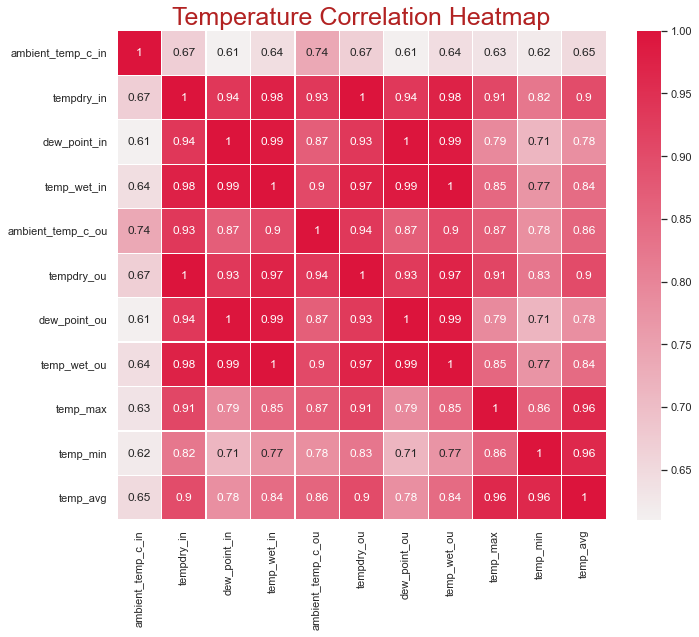

In [6]:
### look at correlation within the temprature features.
alltemp=['ambient_temp_c_in','tempdry_in', 'dew_point_in','temp_wet_in',
          'ambient_temp_c_ou','tempdry_ou', 'dew_point_ou', 'temp_wet_ou',
          'temp_max', 'temp_min', 'temp_avg']
hm_temp=eda_riopa[alltemp]

hm_temp_corr= hm_temp.corr()
cor1=sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(11, 9))
cor1=ax.set_title('Temperature Correlation Heatmap', fontsize=25, color='firebrick')
cmapcrimson=sns.light_palette('crimson', as_cmap=True)
cor1=sns.heatmap(hm_temp_corr, annot=True, cmap=cmapcrimson ,
            square=True, linewidth=0.3)
plt.show()

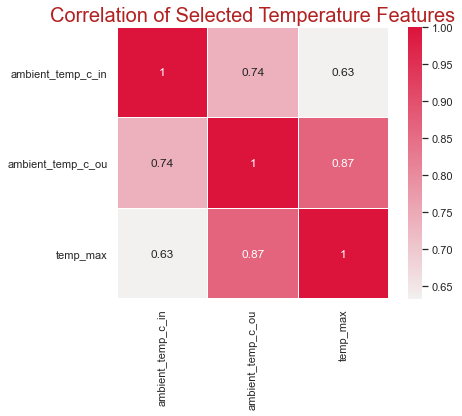

In [7]:
### look at the correlation between selected features.
alltemp=['ambient_temp_c_in','ambient_temp_c_ou','temp_max']
hm_temp2=eda_riopa[alltemp]

hm_temp2_corr= hm_temp2.corr()
cor2=sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(7, 5))
cor2=ax.set_title('Correlation of Selected Temperature Features', fontsize=20, color='firebrick')
cmapcrimson=sns.light_palette('crimson', as_cmap=True)
cor2=sns.heatmap(hm_temp2_corr, annot=True, cmap=cmapcrimson ,
            square=True, linewidth=0.3)
plt.show()

I am going to keep the ambient indoor temperature (ambient_temp_c_in) measured by the riopa team and the maximum temperature from NOAA (temp_max).The reasons behind this choice are:
- the correlation between the two features is the lowest.
- indoor temperatures have been measured by the riopa team and cannot be replaced.
- the maximum temperature from NOAA is the feature of choice for the other model because of the involvement of temperature in ozone formation.

The description of the type of land use in the riopa dataset is different from the description I assigned to the outdoor air quality data. According to this latter, all measurements in the riopa dataset were performed in the main land use 'Residential' (landuse_main='Residential'). When it comes to the nearest land use type, I can translate the land use of riopa as follow:
- 'resid low', 'unknown', 'urban grass' and 'resid hi' become 'Residential'.
- 'pasture', 'forest mix', 'forest evr', 'forest dec', and 'wetlands' become 'Park'.

In [8]:
### update land use terms.
new_landuse_terms={'resid low':'Residential', 'resid hi':'Residential',
                   'unknown':'Residential','urban grass':'Residential',
                   'pasture':'Park',  'forest mix':'Park', 'forest evr':'Park',
                   'forest dec':'Park', 'wetlands':'Park'}
eda_riopa_fix=eda_riopa.copy()
eda_riopa_fix['landuse'].replace(new_landuse_terms, inplace=True)
eda_riopa_fix['landuse_main']='Residential'
eda_riopa_fix['landuse_near']= eda_riopa_fix['landuse']

The final step before encoding is to remove the unneeded columns  which include the obsolete land use and temperatures column, columns with ID and locations, the non-transformed columns, and date.

In [9]:
### remove unneeded columns/features.
tobedropped= ['landuse', 'common_id', 'tempdry_in', 'dew_point_in', 
              'temp_wet_in', 'rh_in', 'ambient_temp_c_ou',
              'ambient_rh_ou', 'tempdry_ou', 'dew_point_ou', 'temp_wet_ou', 
              'station_code', 'station_lat', 'station_lon', 'station_name',
              'temp_min',  'temp_avg']

eda_riopa_fix.drop(columns=tobedropped, inplace=True)
eda_riopa_fix2=eda_riopa_fix.copy()
eda_riopa_fix2.drop(columns=['pm25_in','pm25_ou'], inplace=True)

In [10]:
### remove index date
eda_riopa_fix2.reset_index(inplace=True)
eda_riopa_fix2.drop(columns='date', inplace=True)
eda_riopa_fix.reset_index(inplace=True)
eda_riopa_fix.drop(columns='date', inplace=True)

### drop duplicates
eda_riopa_fix2.drop_duplicates(inplace=True)
eda_riopa_fix.drop_duplicates(inplace=True)
eda_riopa_fix2.head()

,pm25_pt_in,ambient_temp_c_in,airexrate_in,ambient_rh_in,pm25_pt_ou,rh_ou,dust_sand,rain_prcp,smoke_haze,temp_max,thunder,wind_avgspeed,wind_fastest_2min,fog_all,snow_all,rain_all,wind_dmg,wind_all,landuse_main,landuse_near
0,-1.418383,25.07,0.255743,49.92,-1.007883,86.693867,0,0.19,0,91.0,1,4.70,17.9,0,0,0,0,1,Residential,Residential
2,-1.505118,25.07,0.698560,49.92,0.647722,75.707500,0,0.00,1,93.0,0,4.70,13.0,1,1,1,1,1,Residential,Residential
4,-1.283554,26.30,0.449691,49.29,-0.491043,76.490767,0,0.00,0,97.0,0,3.36,14.1,0,0,0,0,1,Residential,Residential
6,0.647719,26.41,0.269475,40.01,-0.129389,69.065233,0,0.00,0,98.0,0,2.46,13.0,1,1,1,1,1,Residential,Residential
8,0.647719,26.41,0.269475,40.01,-0.273137,69.215267,0,0.00,0,98.0,0,2.46,13.0,1,1,1,1,1,Residential,Residential


The dataset is ready. Categorical data need to be OneHot encoded and numerical data need to be scaled.

In [11]:
### endode categorical values
feat_riopa=pd.get_dummies(eda_riopa_fix2)
feat_riopa_all=pd.get_dummies(eda_riopa_fix)
feat_riopa=feat_riopa.astype({'dust_sand':'uint8','smoke_haze':'uint8','thunder':'uint8',
                              'fog_all':'uint8','snow_all':'uint8','rain_all':'uint8',
                              'wind_dmg':'uint8','wind_all':'uint8'})
feat_riopa_all=feat_riopa_all.astype({'dust_sand':'uint8','smoke_haze':'uint8','thunder':'uint8',
                              'fog_all':'uint8','snow_all':'uint8','rain_all':'uint8',
                              'wind_dmg':'uint8','wind_all':'uint8'})

In [12]:
feat_riopa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 404
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pm25_pt_in                186 non-null    float64
 1   ambient_temp_c_in         186 non-null    float64
 2   airexrate_in              186 non-null    float64
 3   ambient_rh_in             186 non-null    float64
 4   pm25_pt_ou                186 non-null    float64
 5   rh_ou                     186 non-null    float64
 6   dust_sand                 186 non-null    uint8  
 7   rain_prcp                 186 non-null    float64
 8   smoke_haze                186 non-null    uint8  
 9   temp_max                  186 non-null    float64
 10  thunder                   186 non-null    uint8  
 11  wind_avgspeed             186 non-null    float64
 12  wind_fastest_2min         186 non-null    float64
 13  fog_all                   186 non-null    uint8  
 14  snow_all  

In [13]:
feat_riopa_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 404
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pm25_in                   186 non-null    float64
 1   pm25_pt_in                186 non-null    float64
 2   ambient_temp_c_in         186 non-null    float64
 3   airexrate_in              186 non-null    float64
 4   ambient_rh_in             186 non-null    float64
 5   pm25_ou                   186 non-null    float64
 6   pm25_pt_ou                186 non-null    float64
 7   rh_ou                     186 non-null    float64
 8   dust_sand                 186 non-null    uint8  
 9   rain_prcp                 186 non-null    float64
 10  smoke_haze                186 non-null    uint8  
 11  temp_max                  186 non-null    float64
 12  thunder                   186 non-null    uint8  
 13  wind_avgspeed             186 non-null    float64
 14  wind_faste

In classification models, AQI categories will replace the concentration values of PM 2.5. I am creating a separate dataframe using the function aqi_cats.

In [14]:
### create AQI categories

## function aqi_cats from EDA
def aqi_cats(dataframe,colpoll):
    aqiwiki={'aqi' : [(0,50),(51,100),(101,150),(151,200),(201,300)],
             'poll':
             {'ozone' : [(0.0, 55.0),
                        (55.0, 70.0),
                        (70.0, 85.0),
                        (85.0, 105.0),
                        (105.0, 200.0)],
              'co': [(0.0, 4.5),
                    (4.5, 9.5),
                    (9.5, 12.5),
                    (12.5, 15.5),
                    (15.5, 30.5)],
              'no2': [(0.0, 55.0),
                    (55.0, 100.0),
                    (100.0, 360.0),
                    (360.0, 650.0),
                    (650.0, 1250.0)],  
              'so2': [(0.0, 35.0),
                    (35.0, 75.0),
                    (75.0, 185.0),
                    (185.0, 305.0),
                    (305.0, 605.0)],
              'pm25': [(0.0, 12.0),
                    (12.0, 35.5),
                    (35.5, 55.5),
                    (55.5, 150.5),
                    (150.5, 250.5)],
              'pm10': [(0.0, 55.0),
                    (55.0, 155.0),
                    (155.0, 255.0),
                    (255.0, 355.0),
                    (355.0, 425.2)]},
             'aqi_cat' :['no emission','safe','moderate','unhealthy for sensitive groups','unhealthy','very unhealthy']}
    df=dataframe
    aqiwiki_brkpts=aqiwiki['poll'][colpoll]
    aqiwiki_labels=aqiwiki['aqi_cat']
    colname='aqi_'+colpoll
    df[colname]= np.where(df[colpoll]<aqiwiki_brkpts[0][1],aqiwiki_labels[1],
                                      (np.where(df[colpoll]<aqiwiki_brkpts[1][1],aqiwiki_labels[2],
                                      (np.where(df[colpoll]<aqiwiki_brkpts[2][1],aqiwiki_labels[3],
                                      (np.where(df[colpoll]<aqiwiki_brkpts[3][1],aqiwiki_labels[4],aqiwiki_labels[5])))))))
    return df

In [15]:
feat_riopa_aqi=feat_riopa_all.copy()
feat_riopa_aqi['pm25']=feat_riopa_aqi['pm25_in']
aqi_cats(feat_riopa_aqi,'pm25')
feat_riopa_aqi.rename(columns={'aqi_pm25':'aqi_pm25_in'}, inplace=True)
feat_riopa_aqi.drop(columns=['pm25'], inplace=True)

feat_riopa_aqi['pm25']=feat_riopa_aqi['pm25_ou']
aqi_cats(feat_riopa_aqi,'pm25')
feat_riopa_aqi.rename(columns={'aqi_pm25':'aqi_pm25_ou'}, inplace=True)
feat_riopa_aqi.drop(columns=['pm25'], inplace=True)
feat_riopa_aqi.head()

,pm25_in,pm25_pt_in,ambient_temp_c_in,airexrate_in,ambient_rh_in,pm25_ou,pm25_pt_ou,rh_ou,dust_sand,rain_prcp,...,fog_all,snow_all,rain_all,wind_dmg,wind_all,landuse_main_Residential,landuse_near_Park,landuse_near_Residential,aqi_pm25_in,aqi_pm25_ou
0,5.1,-1.418383,25.07,0.255743,49.92,9.3,-1.007883,86.693867,0,0.19,...,0,0,0,0,1,1,0,1,safe,safe
2,4.8,-1.505118,25.07,0.698560,49.92,17.5,0.647722,75.707500,0,0.00,...,1,1,1,1,1,1,0,1,safe,moderate
4,5.6,-1.283554,26.30,0.449691,49.29,11.4,-0.491043,76.490767,0,0.00,...,0,0,0,0,1,1,0,1,safe,safe
6,19.6,0.647719,26.41,0.269475,40.01,13.1,-0.129389,69.065233,0,0.00,...,1,1,1,1,1,1,0,1,moderate,moderate
8,19.6,0.647719,26.41,0.269475,40.01,12.4,-0.273137,69.215267,0,0.00,...,1,1,1,1,1,1,0,1,moderate,moderate


<a class="anchor" id="section3_1_3"></a>
### 3.1.3. Train Test Split
The aim of this part of the project is to predict the indoor concentration of PM 2.5 (y) from other features (X) which include the outdoor concetration of PM 2.5. The dataset is too small to make multiple training/testing sets so I will just split 70/30.  Although the plan is to use XGBoost for modeling, which is a model that does not mind unscaled data, a scaled X is prepared for testing other types of model. I chose 'RobustScaler' over other types of scaler from scikit learn processing because the outliers are still present in the transformed data while the range of transformed values remains similar to the range obtained with StandardScaler or MixMaxScaler.

In [16]:
### X and y
X=feat_riopa.drop(columns='pm25_pt_in')
y= feat_riopa.pm25_pt_in

print(X.shape,y.shape)

(186, 20) (186,)


In [17]:
### create training and testing sets from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 13)

### Scaling X_train, X_test
scaler=RobustScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [18]:
print(X_train.shape, X_train_scaled.shape, y_train.shape)

(130, 20) (130, 20) (130,)


In [19]:
print(X_test.shape, X_test_scaled.shape, y_test.shape)

(56, 20) (56, 20) (56,)


In [20]:
X_train.describe()

,ambient_temp_c_in,airexrate_in,ambient_rh_in,pm25_pt_ou,rh_ou,dust_sand,rain_prcp,smoke_haze,temp_max,thunder,wind_avgspeed,wind_fastest_2min,fog_all,snow_all,rain_all,wind_dmg,wind_all,landuse_main_Residential,landuse_near_Park,landuse_near_Residential
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,130.0,130.000000,130.000000
mean,24.428759,0.973426,52.049218,-0.026536,74.420762,0.0,0.125077,0.084615,84.776923,0.192308,6.111769,17.552308,0.715385,0.715385,0.715385,0.715385,1.0,1.0,0.423077,0.576923
std,2.334468,1.864987,7.030578,0.935385,9.368556,0.0,0.331177,0.279385,11.504138,0.395638,2.453579,5.012762,0.452977,0.452977,0.452977,0.452977,0.0,0.0,0.495959,0.495959
min,15.560000,0.081988,35.373800,-3.226980,47.787800,0.0,0.000000,0.000000,52.000000,0.000000,2.460000,10.100000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,23.110750,0.272618,47.829408,-0.653534,67.862467,0.0,0.000000,0.000000,76.250000,0.000000,4.030000,14.100000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
50%,24.392000,0.473221,51.137183,-0.119392,76.261183,0.0,0.000000,0.000000,85.000000,0.000000,5.590000,16.550000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.000000,1.000000
75%,26.048550,0.784742,57.452025,0.643799,82.467050,0.0,0.000000,0.000000,96.000000,0.000000,7.995000,19.900000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000
max,30.460000,13.343200,70.570100,2.557224,90.751867,0.0,1.550000,1.000000,104.000000,1.000000,14.540000,40.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000


<a class="anchor" id="section3_1_4"></a>
### 3.1.4. Export to File

In [21]:
### Export the cleaned dataframe
feat_riopa.to_csv(path_header+path_feat+'feat_riopa.csv')
feat_riopa_all.to_csv(path_header+path_feat+'feat_riopa_all.csv')
feat_riopa_aqi.to_csv(path_header+path_feat+'feat_riopa_aqi.csv')
### Export train/test sets
X_train.to_csv(path_header+path_feat+'riopa_X_train.csv')
X_test.to_csv(path_header+path_feat+'riopa_X_test.csv')
X_train_scaled.tofile(path_header+path_feat+'riopa_X_train_scaled.csv',sep=",", format="%s")
X_test_scaled.tofile(path_header+path_feat+'riopa_X_test_scaled.csv', sep=",", format="%s")

y_train.to_csv(path_header+path_feat+'riopa_y_train.csv')
y_test.to_csv(path_header+path_feat+'riopa_y_test.csv')

<a class="anchor" id="section3_2"></a>
## 3.2. Outdoor Air Quality (TECQ/EPA)

In [22]:
eda_ozone.head()

,ozone,site_lat,site_lon,landuse_main,landuse_near,dust_sand,rain_prcp,smoke_haze,station_code,station_lat,...,wind_dmg,temp_avg,wind_all,year,date.1,traffic,traffic_bins,growth,pop_binned,pop_bins
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,39.0,29.254474,-94.861289,Residential,Park,0,0.0,0,USW00012923,29.2733,...,0,54.0,1,2008,2008-01-01,284100.0,T3,1.85193,"(1.75, 2.0]",P6
2008-01-01,39.0,29.254474,-94.861289,Residential,Park,0,0.0,0,USW00012923,29.2733,...,0,54.0,1,2008,2008-01-01,284100.0,T3,1.85193,"(1.75, 2.0]",P6
2008-01-01,39.0,29.254474,-94.861289,Residential,Park,0,0.0,0,USW00012923,29.2733,...,0,54.0,1,2008,2008-01-01,284100.0,T3,1.85193,"(1.75, 2.0]",P6
2008-01-01,39.0,29.254474,-94.861289,Residential,Park,0,0.0,0,USW00012923,29.2733,...,0,54.0,1,2008,2008-01-01,284100.0,T3,1.85193,"(1.75, 2.0]",P6
2008-01-01,39.0,29.254474,-94.861289,Residential,Park,0,0.0,0,USW00012923,29.2733,...,0,54.0,1,2008,2008-01-01,284100.0,T3,1.85193,"(1.75, 2.0]",P6


In [23]:
eda_ozone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1206824 entries, 2008-01-01 to 2020-09-01
Data columns (total 30 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ozone              1206824 non-null  float64
 1   site_lat           1206824 non-null  float64
 2   site_lon           1206824 non-null  float64
 3   landuse_main       1206824 non-null  object 
 4   landuse_near       1206824 non-null  object 
 5   dust_sand          1206824 non-null  int64  
 6   rain_prcp          1206824 non-null  float64
 7   smoke_haze         1206824 non-null  int64  
 8   station_code       1206824 non-null  object 
 9   station_lat        1206824 non-null  float64
 10  station_lon        1206824 non-null  float64
 11  station_name       1206824 non-null  object 
 12  temp_max           1206824 non-null  int64  
 13  temp_min           1206824 non-null  int64  
 14  thunder            1206824 non-null  int64  
 15  wind_avgspeed      120682

<a class="anchor" id="section3_2_1"></a>
### 3.2.1. Considerations
The outdoor air quality data from EPA/Tamis is composed of 6 dataframes, each containing the infromation about one pollutant: ozone, CO, NO2, SO2, PM 2.5 and PM 10.
The first step of the feature engineering is to clean up the dataframes. The second step addresses potential alternate ways to model the data.
Cleaning up the dataframes involve:
- create month and day columns.
- remove unneeded columns and simplify temperature data by keeping only the maximum temperature
- get dummies on categorical data.
- check columns and drop date index.
- create train/test sets and export files for modeling.

With XGBoost the plan is to model each pollutant individually. I am also interested to see if ozone could be predicted from other pollutants in the following cases:
- one air station records multiple pollutants.
- by date, regardless of station location.

Another interesting test is to try to model using two different y:
- the actual concentration of ozone (i.e. the number ug/m3).
- the AQI category (i.e. safe, moderate, unhealthy...).

<a class="anchor" id="section3_2_2"></a>
### 3.2.2. Feature Engineering Coding

We saw in the EDA that the concentrations of pollutants may vary seasonally or monthly or weekly and may be affected by special events throughout the year and consistently one year after the other. To keep this trend alive in the data after the date index is dropped, a 'month' column and a 'day' column are added as categorical feature. 

In [24]:
### A quick function to extract name of day and name of month from 
### a date index
def month_day_extraction(dataframe):
    global df
    df=dataframe
    '''reset index'''
    df.reset_index(inplace=True)
    '''it is date'''
    df['date'] = pd.to_datetime(df['date'])
    '''create month column'''
    df['month'] = df['date'].dt.strftime('%B')
    '''create day column'''
    df['day'] = df['date'].dt.strftime('%A')
    '''reset index to date'''
    df.set_index('date', inplace=True)
    ''' return modified dataframe'''
    return df    

In [25]:
poll_df=[eda_co, eda_no2, eda_ozone, eda_pm10, eda_pm25, eda_so2]
for poll in poll_df:
    month_day_extraction(poll)

In [26]:
eda_co.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 577289 entries, 2008-01-01 to 2020-06-01
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   co                 577289 non-null  float64
 1   site_lat           577289 non-null  float64
 2   site_lon           577289 non-null  float64
 3   landuse_main       577289 non-null  object 
 4   landuse_near       577289 non-null  object 
 5   dust_sand          577289 non-null  int64  
 6   rain_prcp          577289 non-null  float64
 7   smoke_haze         577289 non-null  int64  
 8   station_code       577289 non-null  object 
 9   station_lat        577289 non-null  float64
 10  station_lon        577289 non-null  float64
 11  station_name       577289 non-null  object 
 12  temp_max           577289 non-null  int64  
 13  temp_min           577289 non-null  int64  
 14  thunder            577289 non-null  int64  
 15  wind_avgspeed      577289 non-null 

The useful columns are subset in new dataframes prior to getting dummies, dropping the date index and duplicates.

In [27]:
### clean up dataframes for individual modeling
fix_ozone=eda_ozone[['ozone','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all']].copy()
                   
fix_co=eda_co[['co','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all']].copy()

fix_no2=eda_no2[['no2','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all']].copy()

fix_so2=eda_so2[['so2','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all']].copy()

fix_pm25=eda_pm25[['pm25','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all']].copy()

fix_pm10=eda_pm10[['pm10','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all']].copy()

### clean up dataframes for ozone prediction modeling
altfix_ozone=eda_ozone[['ozone','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all', 'site_lat', 'site_lon']].copy()
                  
altfix_co=eda_co[['co','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all', 'site_lat', 'site_lon']].copy()

altfix_no2=eda_no2[['no2','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all','site_lat', 'site_lon']].copy()

altfix_so2=eda_so2[['so2','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all','site_lat', 'site_lon']].copy()

altfix_pm25=eda_pm25[['pm25','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all','site_lat', 'site_lon']].copy()
altfix_pm10=eda_pm10[['pm10','landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins','temp_max',  'month', 'day',
                   'dust_sand', 'rain_prcp', 'smoke_haze', 'thunder', 'fog_all', 'snow_all', 'rain_all',
                   'wind_avgspeed', 'wind_fastest_2min', 'wind_dmg', 'wind_all','site_lat', 'site_lon']].copy()

In [28]:
### create the function dummies_uint8 to get dummies and convert weather binaries to uint8
def dummies_uint8(dataframe):
    global df
    df=dataframe
    '''convert weather binaries to uint8'''
    df=df.astype({'dust_sand':'uint8','smoke_haze':'uint8','thunder':'uint8',
                              'fog_all':'uint8','snow_all':'uint8','rain_all':'uint8',
                              'wind_dmg':'uint8','wind_all':'uint8'})
    ''' get dummies'''
    df=pd.get_dummies(df)
    '''return modified dataframe'''
    return df

def drop_date_and_duplicates(dataframe):
    global df
    df=dataframe
    '''reset index'''
    df.reset_index(inplace=True)
    '''drop column date'''
    df.drop(columns='date', inplace=True)
    '''drop duplicates'''
    df.drop_duplicates(inplace=True)
    return df

In [29]:
##### Dataframes for individual pollutant modelling

### use the function dummies_uint8 only on the ozone dataframe
feat_ozone= drop_date_and_duplicates(dummies_uint8(fix_ozone))
feat_co= drop_date_and_duplicates(dummies_uint8(fix_co))
feat_no2= drop_date_and_duplicates(dummies_uint8(fix_no2))
feat_so2= drop_date_and_duplicates(dummies_uint8(fix_so2))
feat_pm25= drop_date_and_duplicates(dummies_uint8(fix_pm25))
feat_pm10= drop_date_and_duplicates(dummies_uint8(fix_pm10))

In [30]:
feat_ozone.head()

,ozone,temp_max,dust_sand,rain_prcp,smoke_haze,thunder,fog_all,snow_all,rain_all,wind_avgspeed,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,39.0,57,0,0.0,0,0,0,0,0,21.03,...,0,0,0,0,0,0,0,0,1,0
9,38.0,50,0,0.0,0,0,0,0,0,18.34,...,0,0,0,0,0,0,0,0,0,1
18,37.0,51,0,0.0,0,0,0,0,0,10.74,...,0,0,0,0,0,0,0,1,0,0
27,35.0,65,0,0.0,0,0,1,1,1,14.54,...,0,0,0,1,0,0,0,0,0,0
36,37.0,71,0,0.0,0,0,1,1,1,10.51,...,0,0,0,0,0,1,0,0,0,0


For the modeling of ozone formation, I am going to try a couple of combination:
- Ozone predicted by NO2 and features present in the individual dataframes
- Ozone predicted by CO, NO2, SO2, PM 2.5 and features present in the individual dataframes.

In [31]:
##### Dataframes for ozone formation modelling

### import selected stations for ozone formation modeling
selec_stations = pd.read_excel(path_header+path_df+'added\\selected_stations_ozoneformation.xlsx')

### collect latitude and longitude of stations which monitor five
### pollutants in fivepoll_stations (all besides pm10) and
### ozone and no2 only in ozno2_stations
fivepoll_stations=selec_stations.loc[selec_stations.type=='five']
ozno2_stations=selec_stations.loc[selec_stations.type=='ozone and no2']

### lighten the dataframes by dropping duplicates
def lighten(dataframe):
    global df
    df=dataframe
    df.reset_index(inplace=True)
    df.drop_duplicates(inplace=True)
    df.set_index('date', inplace=True)
    return df

### use the function dummies_uint8 and lighten only on the ozone dataframes
feat_alt_ozone=lighten(dummies_uint8(altfix_ozone))

### prepare the other dataframes with lighten
feat_alt_co=lighten(altfix_co)
feat_alt_no2=lighten(altfix_no2)
feat_alt_so2=lighten(altfix_so2)
feat_alt_pm25=lighten(altfix_pm25)

### drop features from co, no2, so2, and pm 2.5 dataframes
### so that the final merged dataframe can be easily explored
col_to_drop=['landuse_main', 'landuse_near', 'traffic_bins', 'pop_bins',
       'temp_max', 'month', 'day', 'dust_sand', 'rain_prcp', 'smoke_haze',
       'thunder', 'fog_all', 'snow_all', 'rain_all', 'wind_avgspeed',
       'wind_fastest_2min', 'wind_dmg', 'wind_all']
feat_alt_co_light=feat_alt_co.drop(columns=col_to_drop, inplace=False)
feat_alt_no2_light=feat_alt_no2.drop(columns=col_to_drop, inplace=False)
feat_alt_so2_light=feat_alt_so2.drop(columns=col_to_drop, inplace=False)
feat_alt_pm25_light=feat_alt_pm25.drop(columns=col_to_drop, inplace=False)


### filter dataframes using fivepoll_stations
five_lat=fivepoll_stations.site_lat
five_ozone=feat_alt_ozone.loc[feat_alt_ozone.site_lat.isin(five_lat)]
five_co=feat_alt_co_light.loc[feat_alt_co_light.site_lat.isin(five_lat)]
five_no2=feat_alt_no2_light.loc[feat_alt_no2_light.site_lat.isin(five_lat)]
five_so2=feat_alt_so2_light.loc[feat_alt_so2_light.site_lat.isin(five_lat)]
five_pm25=feat_alt_pm25_light.loc[feat_alt_pm25_light.site_lat.isin(five_lat)]

### filter ozone and no2 dataframes using ozno2_stations
ozno2_lat=ozno2_stations.site_lat
ozno2_ozone=feat_alt_ozone.loc[feat_alt_ozone.site_lat.isin(ozno2_lat)]
ozno2_no2=feat_alt_no2_light.loc[feat_alt_no2_light.site_lat.isin(ozno2_lat)]

### merge 'five' dataframes together on date, site_lat, site_lon
five_df=[five_ozone, five_co, five_no2, five_so2, five_pm25]
merged_five = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, on=['date','site_lat','site_lon'], how='outer'), five_df)

### merge ozno2_ozone with ozno2_no2
merged_ozno2= pd.merge(ozno2_ozone, ozno2_no2, on=['date','site_lat','site_lon'], how='left')

### drop site_lat and site_lon columns
merged_five_light=merged_five.drop(columns=['site_lon','site_lat'], inplace=False)
merged_ozno2_light=merged_ozno2.drop(columns=['site_lon','site_lat'], inplace=False)

### reset index, drop 'date' columns, and remove duplicates (if any)
fivepoll=drop_date_and_duplicates(merged_five_light)
ozno2poll=drop_date_and_duplicates(merged_ozno2_light)

### drop any rows with NaN values
fivepoll.dropna(axis=0, how='any', inplace=True)
ozno2poll.dropna(axis=0, how='any', inplace=True)

Last step is to create from each of these dataframes the version where the poluutant concentration is replaced by the AQI category (i.e. safe, moderate, unhealthy).

In [32]:
### apply aqi_cats to all dataframes
feat_aqi_ozone=feat_ozone.copy()
aqi_cats(feat_aqi_ozone,'ozone')
feat_aqi_ozone.drop(columns='ozone', inplace=True)

feat_aqi_co=feat_co.copy()
aqi_cats(feat_aqi_co,'co')
feat_aqi_co.drop(columns='co', inplace=True)

feat_aqi_no2=feat_no2.copy()
aqi_cats(feat_aqi_no2,'no2')
feat_aqi_no2.drop(columns='no2', inplace=True)

feat_aqi_so2=feat_so2.copy()
aqi_cats(feat_aqi_so2,'so2')
feat_aqi_so2.drop(columns='so2', inplace=True)

feat_aqi_pm25=feat_pm25.copy()
aqi_cats(feat_aqi_pm25,'pm25')
feat_aqi_pm25.drop(columns='pm25', inplace=True)

feat_aqi_pm10=feat_pm10.copy()
aqi_cats(feat_aqi_pm10,'pm10')
feat_aqi_pm10.drop(columns='pm10', inplace=True)

fivepoll_aqi=fivepoll.copy()
aqi_cats(fivepoll_aqi,'ozone')
aqi_cats(fivepoll_aqi,'co')
aqi_cats(fivepoll_aqi,'no2')
aqi_cats(fivepoll_aqi,'so2')
aqi_cats(fivepoll_aqi,'pm25')
fivepoll_aqi.drop(columns=['ozone','co','no2','so2','pm25'], inplace=True)

ozno2poll_aqi=ozno2poll.copy()
aqi_cats(ozno2poll_aqi,'ozone')
aqi_cats(ozno2poll_aqi,'no2')
ozno2poll_aqi.drop(columns=['ozone','no2'], inplace=True)

In [33]:
feat_aqi_co.aqi_co.unique()

array(['safe', 'moderate'], dtype=object)

The dataframes are ready! Their sizes are compatible with XGBoost modeling because:
- they have a large number of training samples (1000+) and less than 100 features.
- the number of features is orders smaller than the number of training samples.
- they contain a mix of numerical and categorical features.

In [34]:
print('shape of individual pollutant dataframes feat_xx:')
print('     ozone', feat_ozone.shape)
print('     co', feat_co.shape)
print('     no2', feat_no2.shape)
print('     so2', feat_so2.shape)
print('     PM 2.5', feat_pm25.shape)
print('     PM 10', feat_pm10.shape)
print('     ozone aqi', feat_aqi_ozone.shape)
print('     co aqi', feat_aqi_co.shape)
print('     no2 aqi', feat_aqi_no2.shape)
print('     so2 aqi', feat_aqi_so2.shape)
print('     PM 2.5 aqi', feat_aqi_pm25.shape)
print('     PM 10 aqi', feat_aqi_pm10.shape)
print(' ')
print('shape of dataframes for ozone modeling:')
print('     fivepoll', fivepoll.shape)
print('     ozno2poll', ozno2poll.shape)
print('     fivepoll aqi', fivepoll_aqi.shape)
print('     ozno2poll aqi', ozno2poll_aqi.shape)

shape of individual pollutant dataframes feat_xx:
     ozone (91096, 62)
     co (20239, 56)
     no2 (71104, 63)
     so2 (33276, 58)
     PM 2.5 (50738, 61)
     PM 10 (6952, 60)
     ozone aqi (91096, 62)
     co aqi (20239, 56)
     no2 aqi (71104, 63)
     so2 aqi (33276, 58)
     PM 2.5 aqi (50738, 61)
     PM 10 aqi (6952, 60)
 
shape of dataframes for ozone modeling:
     fivepoll (6232, 66)
     ozno2poll (33384, 63)
     fivepoll aqi (6232, 66)
     ozno2poll aqi (33384, 63)


<a class="anchor" id="section3_2_3"></a>
### 3.2.3. Train Test Split
As stated in section 1.3. XGBoost does not really need scaled data however I would like to try out other types of models. The scikit learn scaler 'RobustScaler' will scale the data and keep the outliers in the transformed data as outliers.

In [35]:
### X and y for individual dataframes
X_ozone=feat_ozone.drop(columns='ozone', inplace=False)
y_ozone= feat_ozone.ozone

X_co=feat_co.drop(columns='co', inplace=False)
y_co= feat_co.co

X_no2=feat_no2.drop(columns='no2', inplace=False)
y_no2=feat_no2.no2

X_so2=feat_so2.drop(columns='so2', inplace=False)
y_so2= feat_so2.so2

X_pm25=feat_pm25.drop(columns='pm25', inplace=False)
y_pm25= feat_pm25.pm25

X_pm10=feat_pm10.drop(columns='pm10', inplace=False)
y_pm10= feat_pm10.pm10

X_aqi_ozone=feat_aqi_ozone.drop(columns='aqi_ozone', inplace=False)
y_aqi_ozone= feat_aqi_ozone.aqi_ozone

X_aqi_co=feat_aqi_co.drop(columns='aqi_co', inplace=False)
y_aqi_co= feat_aqi_co.aqi_co

X_aqi_no2=feat_aqi_no2.drop(columns='aqi_no2', inplace=False)
y_aqi_no2=feat_aqi_no2.aqi_no2

X_aqi_so2=feat_aqi_so2.drop(columns='aqi_so2', inplace=False)
y_aqi_so2= feat_aqi_so2.aqi_so2

X_aqi_pm25=feat_aqi_pm25.drop(columns='aqi_pm25', inplace=False)
y_aqi_pm25= feat_aqi_pm25.aqi_pm25

X_aqi_pm10=feat_aqi_pm10.drop(columns='aqi_pm10', inplace=False)
y_aqi_pm10= feat_aqi_pm10.aqi_pm10


### X and y, and get dummies on X 
X_fivepoll=fivepoll.drop(columns='ozone', inplace=False)
y_fivepoll= fivepoll.ozone

X_aqi_fivepoll=fivepoll_aqi.drop(columns='aqi_ozone', inplace=False)
X_aqi_fivepoll=pd.get_dummies(X_aqi_fivepoll)
y_aqi_fivepoll= fivepoll_aqi.aqi_ozone

X_ozno2=ozno2poll.drop(columns='ozone', inplace=False)
y_ozno2= ozno2poll.ozone

X_aqi_ozno2=ozno2poll_aqi.drop(columns='aqi_ozone', inplace=False)
X_aqi_ozno2=pd.get_dummies(X_aqi_ozno2)
y_aqi_ozno2= ozno2poll_aqi.aqi_ozone

In [36]:
### create training and testing sets from X and y
X_ozone_train, X_ozone_test, y_ozone_train, y_ozone_test = train_test_split(X_ozone, y_ozone, test_size = 0.3, random_state= 13)

X_co_train, X_co_test, y_co_train, y_co_test = train_test_split(X_co, y_co, test_size = 0.3, random_state= 13)

X_no2_train, X_no2_test, y_no2_train, y_no2_test = train_test_split(X_no2, y_no2, test_size = 0.3, random_state= 13)

X_so2_train, X_so2_test, y_so2_train, y_so2_test = train_test_split(X_so2, y_so2, test_size = 0.3, random_state= 13)

X_pm25_train, X_pm25_test, y_pm25_train, y_pm25_test = train_test_split(X_pm25, y_pm25, test_size = 0.3, random_state= 13)

X_pm10_train, X_pm10_test, y_pm10_train, y_pm10_test = train_test_split(X_pm10, y_pm10, test_size = 0.3, random_state= 13)


#X_aqi_ozone_train, X_aqi_ozone_test, y_aqi_ozone_train, y_aqi_ozone_test = train_test_split(X_aqi_ozone, y_aqi_ozone, test_size = 0.3, random_state= 13)

#X_aqi_co_train, X_aqi_co_test, y_aqi_co_train, y_aqi_co_test = train_test_split(X_aqi_co, y_aqi_co, test_size = 0.3, random_state= 13)

#X_aqi_no2_train, X_aqi_no2_test, y_aqi_no2_train, y_aqi_no2_test = train_test_split(X_aqi_no2, y_aqi_no2, test_size = 0.3, random_state= 13)

#X_aqi_so2_train, X_aqi_so2_test, y_aqi_so2_train, y_aqi_so2_test = train_test_split(X_aqi_so2, y_aqi_so2, test_size = 0.3, random_state= 13)

#X_aqi_pm25_train, X_aqi_pm25_test, y_aqi_pm25_train, y_aqi_pm25_test = train_test_split(X_aqi_pm25, y_aqi_pm25, test_size = 0.3, random_state= 13)

#X_aqi_pm10_train, X_aqi_pm10_test, y_aqi_pm10_train, y_aqi_pm10_test = train_test_split(X_aqi_pm10, y_aqi_pm10, test_size = 0.3, random_state= 13)


X_fivepoll_train, X_fivepoll_test, y_fivepoll_train, y_fivepoll_test = train_test_split(X_fivepoll, y_fivepoll, test_size = 0.3, random_state= 13)

X_ozno2_train, X_ozno2_test, y_ozno2_train, y_ozno2_test = train_test_split(X_ozno2, y_ozno2, test_size = 0.3, random_state= 13)

#X_aqi_fivepoll_train, X_aqi_fivepoll_test, y_aqi_fivepoll_train, y_aqi_fivepoll_test = train_test_split(X_aqi_fivepoll, y_aqi_fivepoll, test_size = 0.3, stratify=y_aqi_fivepoll, random_state= 13)

#X_aqi_ozno2_train, X_aqi_ozno2_test, y_aqi_ozno2_train, y_aqi_ozno2_test = train_test_split(X_aqi_ozno2, y_aqi_ozno2, test_size = 0.3, stratify= y_aqi_ozno2 , random_state= 13)

In [37]:
### Scaling X_train, X_test
ozone_scaler=RobustScaler()
co_scaler=RobustScaler()
no2_scaler=RobustScaler()
so2_scaler=RobustScaler()
pm25_scaler=RobustScaler()
pm10_scaler=RobustScaler()

ozone_aqi_scaler=RobustScaler()
co_aqi_scaler=RobustScaler()
no2_aqi_scaler=RobustScaler()
so2_aqi_scaler=RobustScaler()
pm25_aqi_scaler=RobustScaler()
pm10_aqi_scaler=RobustScaler()

fivepoll_scaler=RobustScaler()
fivepoll_aqi_scaler=RobustScaler()
ozno2_scaler=RobustScaler()
ozno2_aqi_scaler=RobustScaler()


X_ozone_train_scaled=ozone_scaler.fit_transform(X_ozone_train)
X_ozone_test_scaled=ozone_scaler.transform(X_ozone_test)

X_co_train_scaled=co_scaler.fit_transform(X_co_train)
X_co_test_scaled=co_scaler.transform(X_co_test)

X_no2_train_scaled=no2_scaler.fit_transform(X_no2_train)
X_no2_test_scaled=no2_scaler.transform(X_no2_test)

X_so2_train_scaled=so2_scaler.fit_transform(X_so2_train)
X_so2_test_scaled=so2_scaler.transform(X_so2_test)

X_pm25_train_scaled=pm25_scaler.fit_transform(X_pm25_train)
X_pm25_test_scaled=pm25_scaler.transform(X_pm25_test)

X_pm10_train_scaled=pm10_scaler.fit_transform(X_pm10_train)
X_pm10_test_scaled=pm10_scaler.transform(X_pm10_test)


#X_aqi_ozone_train_scaled=ozone_aqi_scaler.fit_transform(X_aqi_ozone_train)
#X_aqi_ozone_test_scaled=ozone_aqi_scaler.transform(X_aqi_ozone_test)

#X_aqi_co_train_scaled=co_aqi_scaler.fit_transform(X_aqi_co_train)
#X_aqi_co_test_scaled=co_aqi_scaler.transform(X_aqi_co_test)

#X_aqi_no2_train_scaled=no2_aqi_scaler.fit_transform(X_aqi_no2_train)
#X_aqi_no2_test_scaled=no2_aqi_scaler.transform(X_aqi_no2_test)

#X_aqi_so2_train_scaled=so2_aqi_scaler.fit_transform(X_aqi_so2_train)
#X_aqi_so2_test_scaled=so2_aqi_scaler.transform(X_aqi_so2_test)

#X_aqi_pm25_train_scaled=pm25_aqi_scaler.fit_transform(X_aqi_pm25_train)
#X_aqi_pm25_test_scaled=pm25_aqi_scaler.transform(X_aqi_pm25_test)

#X_aqi_pm10_train_scaled=pm10_aqi_scaler.fit_transform(X_aqi_pm10_train)
#X_aqi_pm10_test_scaled=pm10_aqi_scaler.transform(X_aqi_pm10_test)


X_fivepoll_train_scaled=fivepoll_scaler.fit_transform(X_fivepoll_train)
X_fivepoll_test_scaled=fivepoll_scaler.transform(X_fivepoll_test)

X_ozno2_train_scaled=ozno2_scaler.fit_transform(X_ozno2_train)
X_ozno2_test_scaled=ozno2_scaler.transform(X_ozno2_test)

#X_aqi_fivepoll_train_scaled=fivepoll_aqi_scaler.fit_transform(X_aqi_fivepoll_train)
#X_aqi_fivepoll_test_scaled=fivepoll_aqi_scaler.transform(X_aqi_fivepoll_test)

#X_aqi_ozno2_train_scaled=ozno2_aqi_scaler.fit_transform(X_aqi_ozno2_train)
#X_aqi_ozno2_test_scaled=ozno2_aqi_scaler.transform(X_aqi_ozno2_test)

In [38]:
print('ozone - train',X_ozone_train.shape, X_ozone_train_scaled.shape, y_ozone_train.shape)
print('ozone - test',X_ozone_test.shape, X_ozone_test_scaled.shape, y_ozone_test.shape)
#print('ozone aqi - train',X_aqi_ozone_train.shape, X_aqi_ozone_train_scaled.shape, y_aqi_ozone_train.shape)
#print('ozone aqi - test',X_aqi_ozone_test.shape, X_aqi_ozone_test_scaled.shape, y_aqi_ozone_test.shape)

print('co - train',X_co_train.shape, X_co_train_scaled.shape, y_co_train.shape)
print('co - test',X_co_test.shape, X_co_test_scaled.shape, y_co_test.shape)
#print('co aqi - train',X_aqi_co_train.shape, X_aqi_co_train_scaled.shape, y_aqi_co_train.shape)
#print('co aqi - test',X_aqi_co_test.shape, X_aqi_co_test_scaled.shape, y_aqi_co_test.shape)

print('no2 - train',X_no2_train.shape, X_no2_train_scaled.shape, y_no2_train.shape)
print('no2 - test',X_no2_test.shape, X_no2_test_scaled.shape, y_no2_test.shape)
#print('no2 aqi - train',X_aqi_no2_train.shape, X_aqi_no2_train_scaled.shape, y_aqi_no2_train.shape)
#print('no2 aqi - test',X_aqi_no2_test.shape, X_aqi_no2_test_scaled.shape, y_aqi_no2_test.shape)

print('so2 - train',X_so2_train.shape, X_so2_train_scaled.shape, y_so2_train.shape)
print('so2 - test',X_so2_test.shape, X_so2_test_scaled.shape, y_so2_test.shape)
#print('so2 aqi - train',X_aqi_so2_train.shape, X_aqi_so2_train_scaled.shape, y_aqi_so2_train.shape)
#print('so2 aqi - test',X_aqi_so2_test.shape, X_aqi_so2_test_scaled.shape, y_aqi_so2_test.shape)

print('PM 2.5 - train',X_pm25_train.shape, X_pm25_train_scaled.shape, y_pm25_train.shape)
print('PM 2.5 - test',X_pm25_test.shape, X_pm25_test_scaled.shape, y_pm25_test.shape)
#print('PM 2.5 aqi - train',X_aqi_pm25_train.shape, X_aqi_pm25_train_scaled.shape, y_aqi_pm25_train.shape)
#print('PM 2.5 aqi - test',X_aqi_pm25_test.shape, X_aqi_pm25_test_scaled.shape, y_aqi_pm25_test.shape)

print('PM 10 - train',X_pm10_train.shape, X_pm10_train_scaled.shape, y_pm10_train.shape)
print('PM 10 - test',X_pm10_test.shape, X_pm10_test_scaled.shape, y_pm10_test.shape)
#print('PM 10 aqi - train',X_aqi_pm10_train.shape, X_aqi_pm10_train_scaled.shape, y_aqi_pm10_train.shape)
#print('PM 10 aqi - test',X_aqi_pm10_test.shape, X_aqi_pm10_test_scaled.shape, y_aqi_pm10_test.shape)


print('fivepoll - train',X_fivepoll_train.shape, X_fivepoll_train_scaled.shape, y_fivepoll_train.shape)
print('fivepoll - test',X_fivepoll_test.shape, X_fivepoll_test_scaled.shape, y_fivepoll_test.shape)
#print('fivepoll - train',X_aqi_fivepoll_train.shape, X_aqi_fivepoll_train_scaled.shape, y_aqi_fivepoll_train.shape)
#print('fivepoll - test',X_aqi_fivepoll_test.shape, X_aqi_fivepoll_test_scaled.shape, y_aqi_fivepoll_test.shape)

print('ozno2 - train',X_ozno2_train.shape, X_ozno2_train_scaled.shape, y_ozno2_train.shape)
print('ozno2 - test',X_ozno2_test.shape, X_ozno2_test_scaled.shape, y_ozno2_test.shape)
#print('ozno2 - train',X_aqi_ozno2_train.shape, X_aqi_ozno2_train_scaled.shape, y_aqi_ozno2_train.shape)
#print('ozno2 - test',X_aqi_ozno2_test.shape, X_aqi_ozno2_test_scaled.shape, y_aqi_ozno2_test.shape)

ozone - train (63767, 61) (63767, 61) (63767,)
ozone - test (27329, 61) (27329, 61) (27329,)
co - train (14167, 55) (14167, 55) (14167,)
co - test (6072, 55) (6072, 55) (6072,)
no2 - train (49772, 62) (49772, 62) (49772,)
no2 - test (21332, 62) (21332, 62) (21332,)
so2 - train (23293, 57) (23293, 57) (23293,)
so2 - test (9983, 57) (9983, 57) (9983,)
PM 2.5 - train (35516, 60) (35516, 60) (35516,)
PM 2.5 - test (15222, 60) (15222, 60) (15222,)
PM 10 - train (4866, 59) (4866, 59) (4866,)
PM 10 - test (2086, 59) (2086, 59) (2086,)
fivepoll - train (4362, 65) (4362, 65) (4362,)
fivepoll - test (1870, 65) (1870, 65) (1870,)
ozno2 - train (23368, 62) (23368, 62) (23368,)
ozno2 - test (10016, 62) (10016, 62) (10016,)


<a class="anchor" id="section3_2_4"></a>
### 3.2.4. Export to File

In [39]:
### Export the cleaned dataframe
feat_ozone.to_csv(path_header+path_feat+'feat_ozone.csv')
feat_aqi_ozone.to_csv(path_header+path_feat+'feat_aqi_ozone.csv')

feat_co.to_csv(path_header+path_feat+'feat_co.csv')
feat_aqi_co.to_csv(path_header+path_feat+'feat_aqi_co.csv')

feat_no2.to_csv(path_header+path_feat+'feat_no2.csv')
feat_aqi_no2.to_csv(path_header+path_feat+'feat_aqi_no2.csv')

feat_so2.to_csv(path_header+path_feat+'feat_so2.csv')
feat_aqi_so2.to_csv(path_header+path_feat+'feat_aqi_so2.csv')

feat_pm25.to_csv(path_header+path_feat+'feat_pm25.csv')
feat_aqi_pm25.to_csv(path_header+path_feat+'feat_aqi_pm25.csv')

feat_pm10.to_csv(path_header+path_feat+'feat_pm10.csv')
feat_aqi_pm10.to_csv(path_header+path_feat+'feat_aqi_pm10.csv')

fivepoll.to_csv(path_header+path_feat+'feat_fivepoll.csv')
fivepoll_aqi.to_csv(path_header+path_feat+'feat_aqi_fivepoll.csv')

ozno2poll.to_csv(path_header+path_feat+'feat_ozno2poll.csv')
ozno2poll_aqi.to_csv(path_header+path_feat+'feat_aqi_ozno2poll.csv')



I do not export the train/test sets because I am not able to upload them all in the modeling notebook.

In [40]:
### Export train/test sets
'''X_ozone_train.to_csv(path_header+path_feat+'ozone_X_train.csv')
X_ozone_test.to_csv(path_header+path_feat+'ozone_X_test.csv')
#X_ozone_train_scaled.tofile(path_header+path_feat+'ozone_X_train_scaled.csv',sep=",", format="%s")
#X_ozone_test_scaled.tofile(path_header+path_feat+'ozone_X_test_scaled.csv', sep=",", format="%s")
#y_ozone_train.to_csv(path_header+path_feat+'ozone_y_train.csv')
#y_ozone_test.to_csv(path_header+path_feat+'ozone_y_test.csv')

X_aqi_ozone_train.to_csv(path_header+path_feat+'aqi_ozone_X_train.csv')
X_aqi_ozone_test.to_csv(path_header+path_feat+'aqi_ozone_X_test.csv')
X_aqi_ozone_train_scaled.tofile(path_header+path_feat+'aqi_ozone_X_train_scaled.csv',sep=",", format="%s")
X_aqi_ozone_test_scaled.tofile(path_header+path_feat+'aqi_ozone_X_test_scaled.csv', sep=",", format="%s")
y_aqi_ozone_train.to_csv(path_header+path_feat+'aqi_ozone_y_train.csv')
y_aqi_ozone_test.to_csv(path_header+path_feat+'aqi_ozone_y_test.csv')

X_co_train.to_csv(path_header+path_feat+'co_X_train.csv')
X_co_test.to_csv(path_header+path_feat+'co_X_test.csv')
X_co_train_scaled.tofile(path_header+path_feat+'co_X_train_scaled.csv',sep=",", format="%s")
X_co_test_scaled.tofile(path_header+path_feat+'co_X_test_scaled.csv', sep=",", format="%s")
y_co_train.to_csv(path_header+path_feat+'co_y_train.csv')
y_co_test.to_csv(path_header+path_feat+'co_y_test.csv')

X_aqi_co_train.to_csv(path_header+path_feat+'aqi_co_X_train.csv')
X_aqi_co_test.to_csv(path_header+path_feat+'aqi_co_X_test.csv')
X_aqi_co_train_scaled.tofile(path_header+path_feat+'aqi_co_X_train_scaled.csv',sep=",", format="%s")
X_aqi_co_test_scaled.tofile(path_header+path_feat+'aqi_co_X_test_scaled.csv', sep=",", format="%s")
y_aqi_co_train.to_csv(path_header+path_feat+'aqi_co_y_train.csv')
y_aqi_co_test.to_csv(path_header+path_feat+'aqi_co_y_test.csv')

X_no2_train.to_csv(path_header+path_feat+'no2_X_train.csv')
X_no2_test.to_csv(path_header+path_feat+'no2_X_test.csv')
X_no2_train_scaled.tofile(path_header+path_feat+'no2_X_train_scaled.csv',sep=",", format="%s")
X_no2_test_scaled.tofile(path_header+path_feat+'no2_X_test_scaled.csv', sep=",", format="%s")
y_no2_train.to_csv(path_header+path_feat+'no2_y_train.csv')
y_no2_test.to_csv(path_header+path_feat+'no2_y_test.csv')

X_aqi_no2_train.to_csv(path_header+path_feat+'aqi_no2_X_train.csv')
X_aqi_no2_test.to_csv(path_header+path_feat+'aqi_no2_X_test.csv')
X_aqi_no2_train_scaled.tofile(path_header+path_feat+'aqi_no2_X_train_scaled.csv',sep=",", format="%s")
X_aqi_no2_test_scaled.tofile(path_header+path_feat+'aqi_no2_X_test_scaled.csv', sep=",", format="%s")
y_aqi_no2_train.to_csv(path_header+path_feat+'aqi_no2_y_train.csv')
y_aqi_no2_test.to_csv(path_header+path_feat+'aqi_no2_y_test.csv')

X_so2_train.to_csv(path_header+path_feat+'so2_X_train.csv')
X_so2_test.to_csv(path_header+path_feat+'so2_X_test.csv')
X_so2_train_scaled.tofile(path_header+path_feat+'so2_X_train_scaled.csv',sep=",", format="%s")
X_so2_test_scaled.tofile(path_header+path_feat+'so2_X_test_scaled.csv', sep=",", format="%s")
y_so2_train.to_csv(path_header+path_feat+'so2_y_train.csv')
y_so2_test.to_csv(path_header+path_feat+'so2_y_test.csv')

X_aqi_so2_train.to_csv(path_header+path_feat+'aqi_so2_X_train.csv')
X_aqi_so2_test.to_csv(path_header+path_feat+'aqi_so2_X_test.csv')
X_aqi_so2_train_scaled.tofile(path_header+path_feat+'aqi_so2_X_train_scaled.csv',sep=",", format="%s")
X_aqi_so2_test_scaled.tofile(path_header+path_feat+'aqi_so2_X_test_scaled.csv', sep=",", format="%s")
y_aqi_so2_train.to_csv(path_header+path_feat+'aqi_so2_y_train.csv')
y_aqi_so2_test.to_csv(path_header+path_feat+'aqi_so2_y_test.csv')

X_pm25_train.to_csv(path_header+path_feat+'pm25_X_train.csv')
X_pm25_test.to_csv(path_header+path_feat+'pm25_X_test.csv')
X_pm25_train_scaled.tofile(path_header+path_feat+'pm25_X_train_scaled.csv',sep=",", format="%s")
X_pm25_test_scaled.tofile(path_header+path_feat+'pm25_X_test_scaled.csv', sep=",", format="%s")
y_pm25_train.to_csv(path_header+path_feat+'pm25_y_train.csv')
y_pm25_test.to_csv(path_header+path_feat+'pm25_y_test.csv')

X_aqi_pm25_train.to_csv(path_header+path_feat+'aqi_pm25_X_train.csv')
X_aqi_pm25_test.to_csv(path_header+path_feat+'aqi_pm25_X_test.csv')
X_aqi_pm25_train_scaled.tofile(path_header+path_feat+'aqi_pm25_X_train_scaled.csv',sep=",", format="%s")
X_aqi_pm25_test_scaled.tofile(path_header+path_feat+'aqi_pm25_X_test_scaled.csv', sep=",", format="%s")
y_aqi_pm25_train.to_csv(path_header+path_feat+'aqi_pm25_y_train.csv')
y_aqi_pm25_test.to_csv(path_header+path_feat+'aqi_pm25_y_test.csv')

X_pm10_train.to_csv(path_header+path_feat+'pm10_X_train.csv')
X_pm10_test.to_csv(path_header+path_feat+'pm10_X_test.csv')
X_pm10_train_scaled.tofile(path_header+path_feat+'pm10_X_train_scaled.csv',sep=",", format="%s")
X_pm10_test_scaled.tofile(path_header+path_feat+'pm10_X_test_scaled.csv', sep=",", format="%s")
y_pm10_train.to_csv(path_header+path_feat+'pm10_y_train.csv')
y_pm10_test.to_csv(path_header+path_feat+'pm10_y_test.csv')

X_aqi_pm10_train.to_csv(path_header+path_feat+'aqi_pm10_X_train.csv')
X_aqi_pm10_test.to_csv(path_header+path_feat+'aqi_pm10_X_test.csv')
X_aqi_pm10_train_scaled.tofile(path_header+path_feat+'aqi_pm10_X_train_scaled.csv',sep=",", format="%s")
X_aqi_pm10_test_scaled.tofile(path_header+path_feat+'aqi_pm10_X_test_scaled.csv', sep=",", format="%s")
y_aqi_pm10_train.to_csv(path_header+path_feat+'aqi_pm10_y_train.csv')
y_aqi_pm10_test.to_csv(path_header+path_feat+'aqi_pm10_y_test.csv')

X_fivepoll_train.to_csv(path_header+path_feat+'fivepoll_X_train.csv')
X_fivepoll_test.to_csv(path_header+path_feat+'fivepoll_X_test.csv')
X_fivepoll_train_scaled.tofile(path_header+path_feat+'fivepoll_X_train_scaled.csv',sep=",", format="%s")
X_fivepoll_test_scaled.tofile(path_header+path_feat+'fivepoll_X_test_scaled.csv', sep=",", format="%s")
y_fivepoll_train.to_csv(path_header+path_feat+'fivepoll_y_train.csv')
y_fivepoll_test.to_csv(path_header+path_feat+'fivepoll_y_test.csv')

X_aqi_fivepoll_train.to_csv(path_header+path_feat+'aqi_fivepoll_X_train.csv')
X_aqi_fivepoll_test.to_csv(path_header+path_feat+'aqi_fivepoll_X_test.csv')
X_aqi_fivepoll_train_scaled.tofile(path_header+path_feat+'aqi_fivepoll_X_train_scaled.csv',sep=",", format="%s")
X_aqi_fivepoll_test_scaled.tofile(path_header+path_feat+'aqi_fivepoll_X_test_scaled.csv', sep=",", format="%s")
y_aqi_fivepoll_train.to_csv(path_header+path_feat+'aqi_fivepoll_y_train.csv')
y_aqi_fivepoll_test.to_csv(path_header+path_feat+'aqi_fivepoll_y_test.csv')

X_ozno2_train.to_csv(path_header+path_feat+'ozno2poll_X_train.csv')
X_ozno2_test.to_csv(path_header+path_feat+'ozno2poll_X_test.csv')
X_ozno2_train_scaled.tofile(path_header+path_feat+'ozno2poll_X_train_scaled.csv',sep=",", format="%s")
X_ozno2_test_scaled.tofile(path_header+path_feat+'ozno2poll_X_test_scaled.csv', sep=",", format="%s")
y_ozno2_train.to_csv(path_header+path_feat+'ozno2poll_y_train.csv')
y_ozno2_test.to_csv(path_header+path_feat+'ozno2poll_y_test.csv')

X_aqi_ozno2_train.to_csv(path_header+path_feat+'aqi_ozno2poll_X_train.csv')
X_aqi_ozno2_test.to_csv(path_header+path_feat+'aqi_ozno2poll_X_test.csv')
X_aqi_ozno2_train_scaled.tofile(path_header+path_feat+'aqi_ozno2poll_X_train_scaled.csv',sep=",", format="%s")
X_aqi_ozno2_test_scaled.tofile(path_header+path_feat+'aqi_ozno2poll_X_test_scaled.csv', sep=",", format="%s")
y_aqi_ozno2_train.to_csv(path_header+path_feat+'aqi_ozno2poll_y_train.csv')
y_aqi_ozno2_test.to_csv(path_header+path_feat+'aqi_ozno2poll_y_test.csv') '''

'X_ozone_train.to_csv(path_header+path_feat+\'ozone_X_train.csv\')\nX_ozone_test.to_csv(path_header+path_feat+\'ozone_X_test.csv\')\n#X_ozone_train_scaled.tofile(path_header+path_feat+\'ozone_X_train_scaled.csv\',sep=",", format="%s")\n#X_ozone_test_scaled.tofile(path_header+path_feat+\'ozone_X_test_scaled.csv\', sep=",", format="%s")\n#y_ozone_train.to_csv(path_header+path_feat+\'ozone_y_train.csv\')\n#y_ozone_test.to_csv(path_header+path_feat+\'ozone_y_test.csv\')\n\nX_aqi_ozone_train.to_csv(path_header+path_feat+\'aqi_ozone_X_train.csv\')\nX_aqi_ozone_test.to_csv(path_header+path_feat+\'aqi_ozone_X_test.csv\')\nX_aqi_ozone_train_scaled.tofile(path_header+path_feat+\'aqi_ozone_X_train_scaled.csv\',sep=",", format="%s")\nX_aqi_ozone_test_scaled.tofile(path_header+path_feat+\'aqi_ozone_X_test_scaled.csv\', sep=",", format="%s")\ny_aqi_ozone_train.to_csv(path_header+path_feat+\'aqi_ozone_y_train.csv\')\ny_aqi_ozone_test.to_csv(path_header+path_feat+\'aqi_ozone_y_test.csv\')\n\nX_co_trai